In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import gc
import matplotlib.dates as mdates
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms.functional as F_t
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# from vit_pytorch.vit import ViT
from vit_pytorch.efficient import ViT
from linformer import Linformer

%matplotlib inline

In [ ]:
# check torch version
print("pytorch version:", torch.__version__)
# check available gpu
gpus =  torch.cuda.device_count()
print("available gpus:", gpus)

print("available cpus:", os.cpu_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pytorch version: 2.0.0+cu118
available gpus: 1
available cpus: 16


In [ ]:
cwd = os.getcwd()
print(cwd)
print(os.path.dirname(cwd))

# define the data location and load data
cwd = os.getcwd()
data_folder = os.path.join(cwd,"SolarForecastDataset")
data_path = os.path.join(data_folder, "forecast_dataset.hdf5")

C:\Users\sashah8\Neural_nets\vit_pv_forecast
C:\Users\sashah8\Neural_nets


In [ ]:
# !change model name for different models!
model_name = 'ViT_nowcast_2017_2019_data'
output_folder = os.path.join(cwd,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: C:\Users\sashah8\Neural_nets\vit_pv_forecast\SolarForecastDataset
data_path: C:\Users\sashah8\Neural_nets\vit_pv_forecast\SolarForecastDataset\forecast_dataset.hdf5
output_folder: C:\Users\sashah8\Neural_nets\vit_pv_forecast\ViT_Output\model_output\ViT_nowcast_2017_2019_data


In [ ]:
# generate handler for the hdf5 data
nowcast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(nowcast_dataset[name])
    
nowcast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [ ]:
print('-'*50)
# get the input dimension for constructing the model
img_side_len = nowcast_dataset['trainval']['images_log'].shape[1]
num_color_channel = nowcast_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = nowcast_dataset['trainval']['images_log'][idxs]
    _ = nowcast_dataset['trainval']['pv_log'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
nowcast_dataset.close()

--------------------------------------------------
image side length: 64
number of color channels: 3
input image dimension: [64, 64, 3]
times_trainval.shape: (349372,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 69873, 20.00% finished, processing time 0.29s
batch 2 samples: 69874 to 139747, 40.00% finished, processing time 0.28s
batch 3 samples: 139748 to 209621, 60.00% finished, processing time 0.28s
batch 4 samples: 209622 to 279495, 80.00% finished, processing time 0.37s
batch 5 samples: 279496 to 349369, 100.00% finished, processing time 0.29s
batch 6 samples: 349370 to 349371, 100.00% finished, processing time 0.00s


In [ ]:
### converting timestamps to dates, converting to blocks of the same date and then shuffling timestamps within blocks
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [ ]:

### forming train and test validation datasets by making the fold number as the test dataset and rest as training.
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices

    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    #np.random.seed(fold_index)
    #np.random.shuffle(train_indices)
    #np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [ ]:
transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
class dataset(torch.utils.data.Dataset):

    def __init__(self,image,pv,transform=None):
        self.image = image
        self.pv = pv
        self.transform = transform
                
    #dataset length
    def __len__(self):
        self.filelength = len(self.image)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_idx = self.image[idx]
        img_transformed = self.transform(img_idx)
        
        pv_idx = self.pv[idx]
        pv_info = torch.as_tensor(pv_idx, dtype=torch.float32)

        return img_transformed,pv_info

## Model Architecture

In [ ]:
# define training time parameters
num_epochs = 100 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 512
learning_rate = 1e-06

In [ ]:
efficient_transformer = Linformer(
    dim=1024,
    seq_len=16+1,  # 7x7 patches + 1 cls-token
    depth=4,
    heads=4,
    k=32
)

model = ViT(
    dim=1024,
    image_size=64,
    patch_size=16,
    num_classes=1,
    channels=3,
    transformer=efficient_transformer,
    pool='mean',
).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 16, 768]               0
         LayerNorm-2              [-1, 16, 768]           1,536
            Linear-3             [-1, 16, 1024]         787,456
         LayerNorm-4             [-1, 16, 1024]           2,048
         LayerNorm-5             [-1, 17, 1024]           2,048
            Linear-6             [-1, 17, 1024]       1,048,576
            Linear-7             [-1, 17, 1024]       1,048,576
            Linear-8             [-1, 17, 1024]       1,048,576
           Dropout-9            [-1, 4, 17, 32]               0
           Linear-10             [-1, 17, 1024]       1,049,600
LinformerSelfAttention-11             [-1, 17, 1024]               0
          PreNorm-12             [-1, 17, 1024]               0
        LayerNorm-13             [-1, 17, 1024]           2,048
           Linear-14             [

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, path="best_model.pth", trace_func=print):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

##Loading Data and Model Training

In [ ]:
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

indices_train, indices_val = cv_split(indices_dayblock_shuffled,9,num_fold) 
data_path = data_path
indices_train = sorted(indices_train)
indices_val = sorted(indices_val)

with h5py.File(data_path,'r') as f:

    images_log_train = f['trainval']['images_log'][indices_train]
    pv_log_train = f['trainval']['pv_log'][indices_train]
    images_log_val = f['trainval']['images_log'][indices_val]
    pv_log_val = f['trainval']['pv_log'][indices_val]

train_data = dataset(images_log_train, pv_log_train, transform=transforms)
val_data = dataset(images_log_val, pv_log_val, transform= transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True,num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True,num_workers=0)

del train_data,val_data, images_log_train, images_log_val

[Epoch     1 of 100] loss: 69.763199 val_loss: 44.164783
Validation loss decreased (inf --> 44.164783).  Saving model ...
[Epoch     2 of 100] loss: 27.988180 val_loss: 17.017292
Validation loss decreased (44.164783 --> 17.017292).  Saving model ...
[Epoch     3 of 100] loss: 13.258875 val_loss: 11.314338
Validation loss decreased (17.017292 --> 11.314338).  Saving model ...
[Epoch     4 of 100] loss: 10.037229 val_loss: 9.457232
Validation loss decreased (11.314338 --> 9.457232).  Saving model ...
[Epoch     5 of 100] loss: 8.632658 val_loss: 8.267533
Validation loss decreased (9.457232 --> 8.267533).  Saving model ...
[Epoch     6 of 100] loss: 7.607823 val_loss: 7.359253
Validation loss decreased (8.267533 --> 7.359253).  Saving model ...
[Epoch     7 of 100] loss: 6.774397 val_loss: 6.535336
Validation loss decreased (7.359253 --> 6.535336).  Saving model ...
[Epoch     8 of 100] loss: 6.115498 val_loss: 6.029112
Validation loss decreased (6.535336 --> 6.029112).  Saving model ...


<All keys matched successfully>

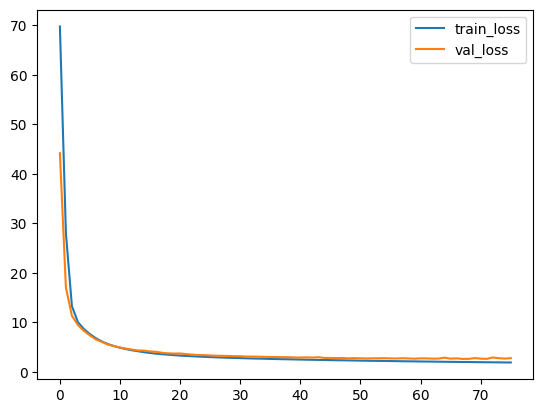

In [ ]:
train_loss_epoch = []
val_loss_epoch = []

save_directory = os.path.join(output_folder,'Model_Checkpoint')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model_path = os.path.join(save_directory,"best_model.pth")
early_stopping = EarlyStopping(patience=8, verbose=True, path=model_path)

for t in range(num_epochs):
  epoch_loss = 0
  model.train()
  for data_train, pv_train in train_loader:
      data_train = data_train.to(device)
      pv_train = pv_train.to(device)
      pred_train = model(data_train)
      loss_train = loss_fn(torch.squeeze(pred_train), pv_train)
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

      epoch_loss += loss_train.detach()/len(train_loader)

  model.eval()
  with torch.no_grad():
      epoch_loss_val = 0
      for data_val, pv_val in val_loader:
          data_val = data_val.to(device)
          pv_val = pv_val.to(device)
          pred_val = model(data_val)
          loss_val = loss_fn(torch.squeeze(pred_val), pv_val)
          epoch_loss_val += loss_val.detach()/len(val_loader)
    
      print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f} val_loss: {val_loss:1.6f}".format(t=t+1,epochs= num_epochs,loss=epoch_loss,val_loss=epoch_loss_val))
      
      train_loss_epoch.append(epoch_loss.item())
      val_loss_epoch.append(epoch_loss_val.item())
      early_stopping(epoch_loss_val, model)
          
      if early_stopping.early_stop:
          print("Early stopping")
          break
      gc.collect()
      
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss_epoch,label='val_loss')
plt.legend()
plt.show

model.load_state_dict(torch.load(model_path))

In [ ]:
best_val_loss_MSE = np.min(val_loss_epoch)
idx = np.argmin(val_loss_epoch)

In [ ]:
best_val_loss_MSE = np.min(val_loss_epoch)
idx = np.argmin(val_loss_epoch)
best_train_loss_MSE = train_loss_epoch[idx]
print('Best Model train loss: {0:.2f}, validation loss: {1:.2f} (RMSE)'.format(np.sqrt(best_train_loss_MSE), np.sqrt(best_val_loss_MSE)))

Best Model train loss: 1.41, validation loss: 1.61 (RMSE)


In [ ]:
del train_loader, val_loader

In [ ]:
gc.collect()

4097

## Model Testing and Evaluation

In [ ]:
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

# read in the data
with h5py.File(data_path,'r') as f:
    
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)


In [ ]:
test_data = dataset(images_log_test, pv_log_test, transform=transforms)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size,num_workers=0)

In [ ]:
print("evaluating performance for the model")
preds_total = []
model.eval()
test_preds = []
avg_loss_test = 0
with torch.no_grad():
  for data_test, pv_test in test_loader:
      data_test = data_test.to(device)
      pv_test = pv_test.to(device)
      pred_test = model(data_test)
      pred_test = torch.squeeze(pred_test)
      preds_list = pred_test.tolist()
      preds_total.extend(preds_list)

      loss_test = loss_fn(pred_test, pv_test)
      avg_loss_test += loss_val/len(test_loader)

print("Test loss: {loss:1.6f}".format(loss=avg_loss_test))
loss_rmse = np.sqrt(avg_loss_test.cpu().data.numpy())
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_rmse))

evaluating performance for the model
Test loss: 0.909223
the test set RMSE is 0.954 for the ensemble model


# TESTING A RANDOM SAMPLE

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

#Converting predictions to array for mask
preds_list_arr = np.asarray(preds_total)

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
preds_list_sunny = preds_list_arr[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
preds_list_cloudy = preds_list_arr[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [ ]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((preds_list_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((preds_list_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.542
test set cloudy days RMSE: 3.544
test set overall RMSE: 2.538


In [ ]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((preds_list_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((preds_list_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.427
test set cloudy days MAE: 2.431
test set overall MAE: 1.431


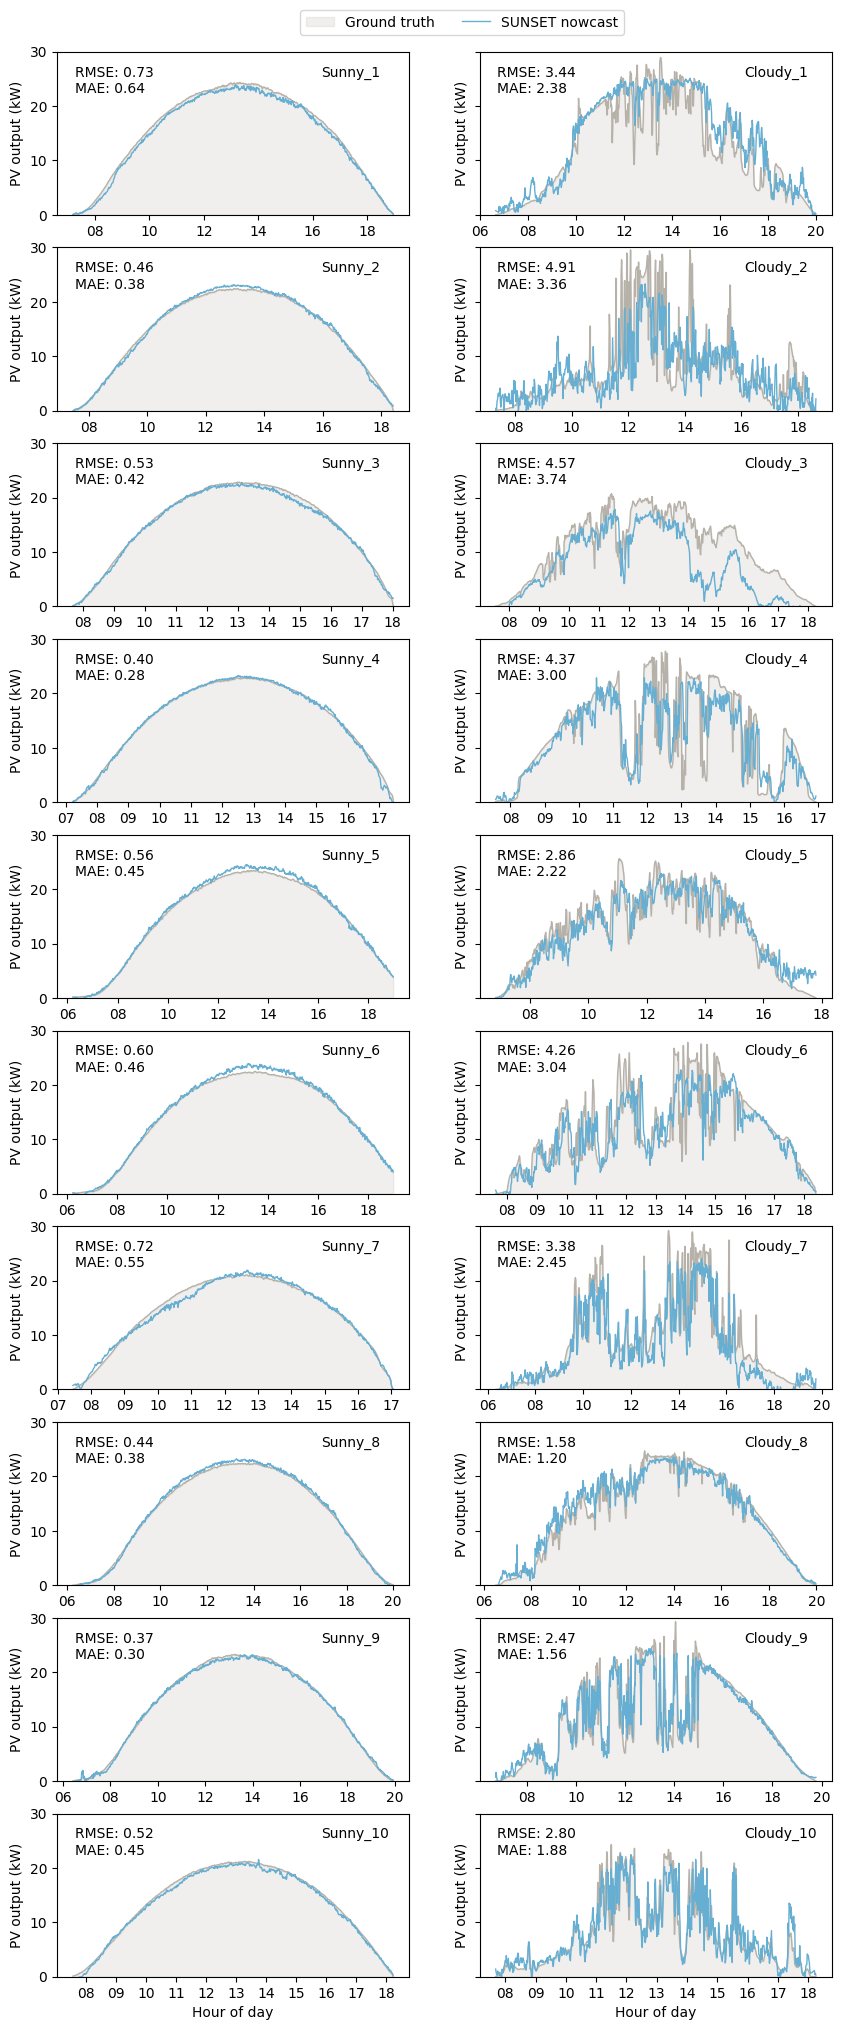

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-preds_list_arr[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-preds_list_arr[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

    
axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)    
plt.show()  

In [ ]:
rmse

2.803483623625269

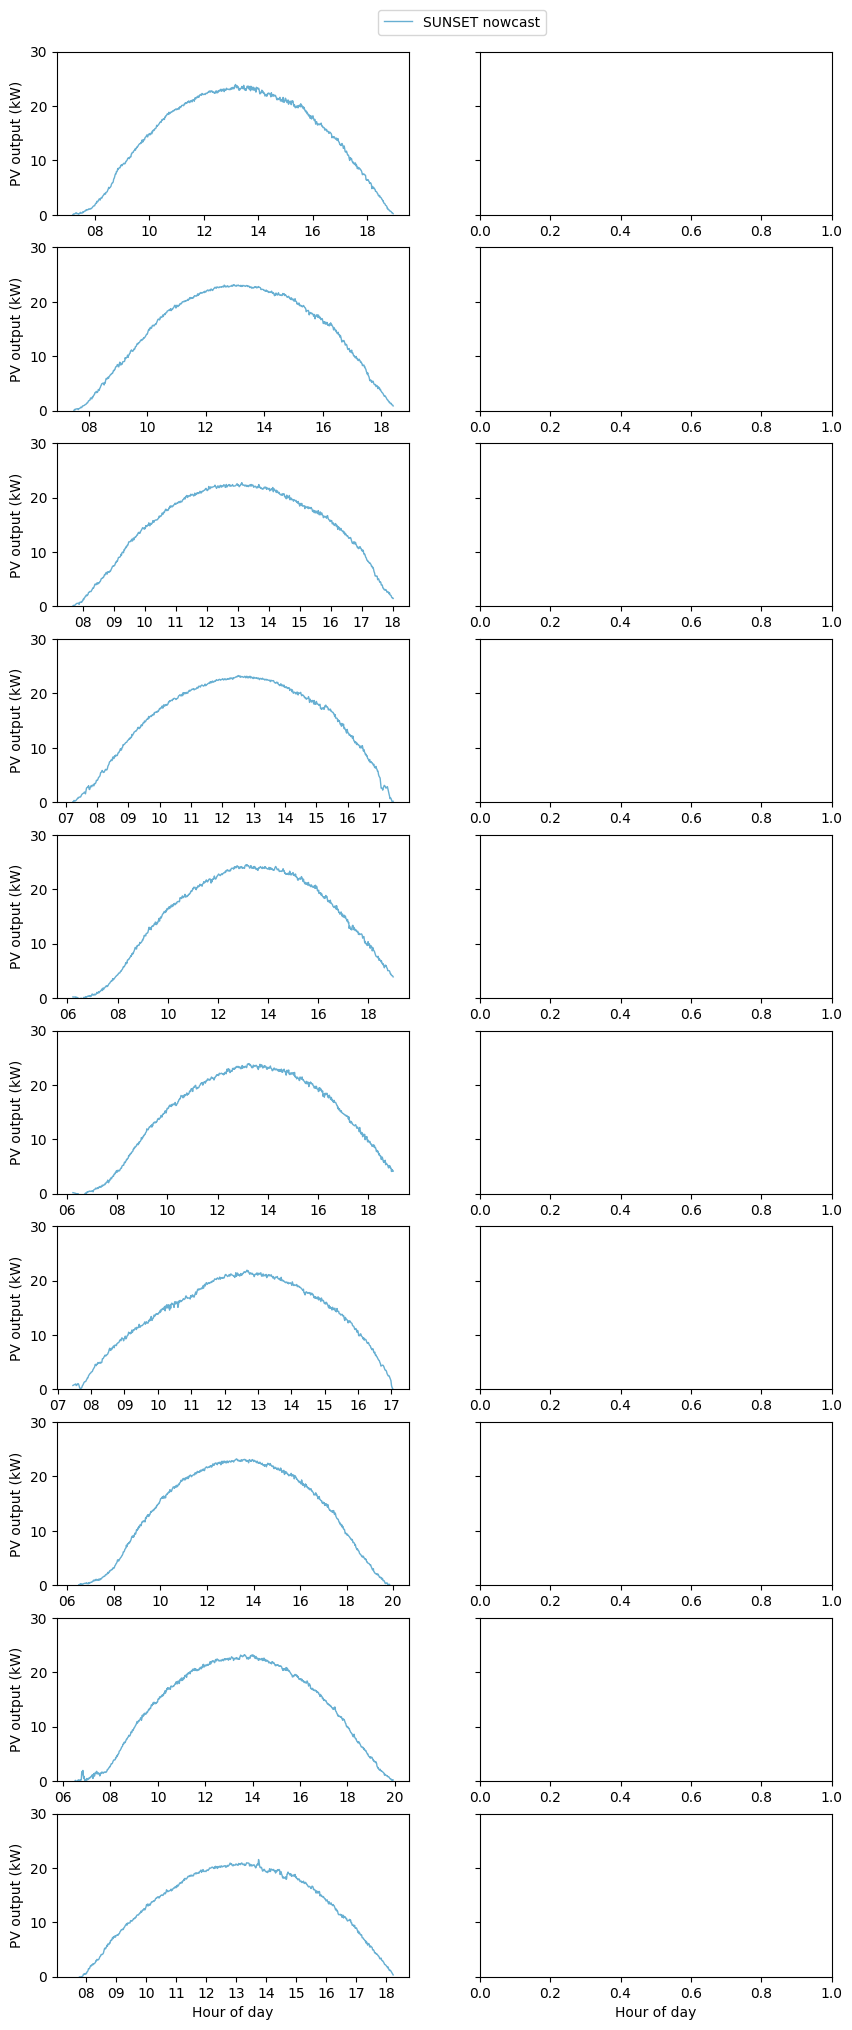

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-preds_list_arr[date_mask])))

    # ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    # ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    # ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    # ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)
plt.show()

plt.show()